## Predict Light Sheet Vessels

In this notebook we test prediction on a full 2D slice

In [28]:
import napari
viewer = napari.Viewer()

from skimage.io import imread
from pathlib import Path
import torch
import numpy as np
from tnia.deeplearning.dl_helper import quantile_normalization
from torchvision import transforms
from torchvision.transforms import v2

## Setup paths

In [29]:
from pathlib import Path
import os
tnia_images_path = Path("D:/images/tnia-python-images")
#tnia_images_path = Path("/home/bnorthan/images/tnia-python-images")
parent_path = tnia_images_path / r"imagesc/2025_03_31_cellpose_not_precise"
parent_path = tnia_images_path / r"imagesc/2025_04_07_cellpose_not_precise_dense"
models_path = parent_path / 'models'

im_name = 'Screenshot from 2025-03-31 10-28-06.png'
im = imread(r"D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\labels\input0\Screenshot from 2025-03-31 10-28-06_0.tif")

im.mean()

32.14168887408395

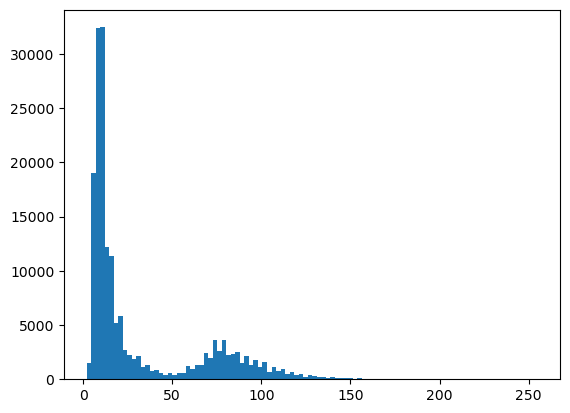

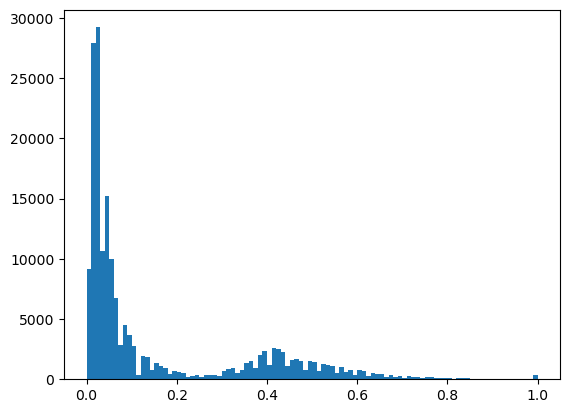

In [30]:
import matplotlib.pyplot as plt

plt.hist(im.flatten(), bins=100)
plt.show()

im_normalized = quantile_normalization(im)

plt.hist(im_normalized.flatten(), bins=100)
plt.show()


## Load unet

In [31]:
net = torch.load( Path(models_path) / 'model_April08_big.pth', weights_only=False)
device = torch.device("cuda")
temp = net.to(device)

## Apply unet

In this cell we apply the unet.  

1.  We have to normalize (need to make sure normalization is done the same way as when the network was trained)
2.  Convert to tensor
3.  Add batch num and channel dimensions with unsqueeze
4.  calculate logits using 
5.  (in a subsequent cell) use softmax and argmax to convert logits to predictions


In [32]:
#im, raw = train_dataset[10]

net.eval()

begin = 20
size = 256
im_cropped = im#[begin:begin+size, begin:begin+size] 

print(im_cropped.shape, im_cropped.min(), im_cropped.max())
# normalize the image
im_normalized = quantile_normalization(im_cropped)
im_normalized = im_normalized.astype(np.float32)
print(im_normalized.shape, im_normalized.min(), im_normalized.max(), im_normalized.mean())

# convert to tensor calling unqueeze twice to add trivial batch and channel dim_normalizedensions
im_tensor = torch.from_numpy(im_normalized).unsqueeze(0).unsqueeze(0).to(device)       
print('input shape', im_tensor.shape)

use_sliding_window = False

if not use_sliding_window:
    with torch.no_grad():
        logits=net(im_tensor)
else:
    from monai.inferers import sliding_window_inference

    with torch.no_grad():
        #logits = net(im_tensor)  # Forward pass through the model
        # Sliding window inference
        logits = sliding_window_inference(
            im_tensor,                      # Input tensor
            256,              # Patch size
            1,                       # Batch size during inference
            net,              # Model for inference
            #overlap=0.125          # Overlap factor

        )

print('output logits shape',logits.shape)
num_classes = logits.shape[1]
print('num classes', num_classes)

(395, 456) 2 255
(395, 456) 0.0 1.0 0.15668917
input shape torch.Size([1, 1, 395, 456])
output logits shape torch.Size([1, 2, 395, 456])
num classes 2


## Plot logits

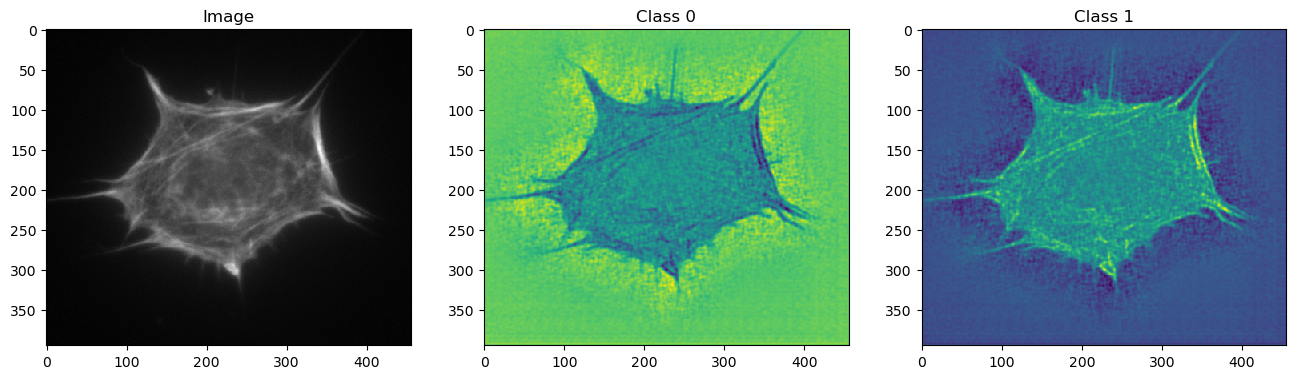

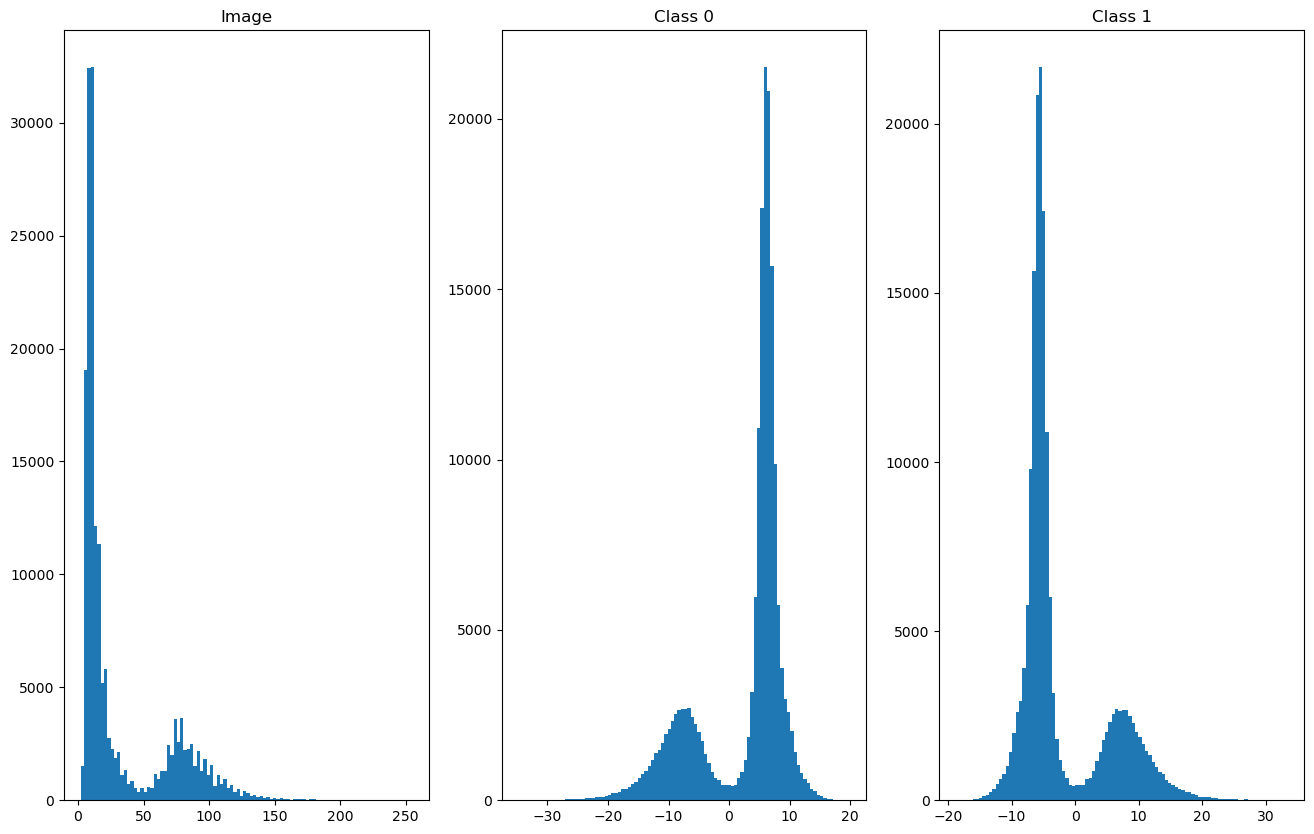

In [33]:
from tnia.plotting.plt_helper import imshow_multi2d

#im = np.transpose(im, (1,2,0))
classes = []
colormaps = []
colormaps.append('gray')

titles = []
titles.append('Image')
for i in range(num_classes):
    classes.append(logits[0,i,:,:].cpu().detach().numpy())
    titles.append('Class ' + str(i))
    colormaps.append('viridis')

images = [im]+classes

fig = imshow_multi2d(images, titles, 1, num_classes+1, 16, 10,colormaps=colormaps)
fig = imshow_multi2d(images, titles, 1, num_classes+1, 16, 10,colormaps=colormaps, plottypes=['hist', 'hist', 'hist'])


In [34]:
viewer = napari.Viewer()

viewer.add_image(im_cropped, name='Image', colormap='gray')

for i in range(num_classes):
    print(classes[i].min(), classes[i].max())
    viewer.add_image(logits[0,i,:,:].cpu().detach().numpy(), name='Class ' + str(i))

-34.820885 19.973564
-18.759815 33.400173


## Convert logits to predictions

In [36]:
import test


logits.shape
test=logits[0,1,:,:]>3
test=test.cpu().detach().numpy()
test.shape
viewer.add_labels(test, name='Class 1 > 3')

<Labels layer 'Class 1 > 3 [1]' at 0x16f8f6a7290>

In [37]:
print(logits.shape)
print("Logit channel 0 (bg):", logits[:,0].mean().item())
print("Logit channel 1 (fg):", logits[:,1].mean().item())
import torch.nn.functional as F

# Apply softmax along the class dimension (dim=1)
probabilities = F.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1) 

torch.Size([1, 2, 395, 456])
Logit channel 0 (bg): 2.586988687515259
Logit channel 1 (fg): -2.231226921081543


In [38]:
viewer.add_labels(predicted_classes.cpu().numpy()+1)

<Labels layer 'Labels' at 0x16f9217b290>

im_cropped min max (256, 256) 4 255
im_normalized min max (256, 256) 0.0 1.0 0.240686161001933 float64
(256, 256) 0.0 1.0
im_cropped min max (256, 256) 5 255
im_normalized min max (256, 256) 0.0 1.0 0.29958334634470385 float64
(256, 256) 0.0 1.0
im_cropped min max (256, 256) 7 218
im_normalized min max (256, 256) 0.0 1.0 0.30850237891787574 float64
(256, 256) 0.0 1.0
im_cropped min max (256, 256) 3 255
im_normalized min max (256, 256) 0.0 1.0 0.2176009328741776 float64
(256, 256) 0.0 1.0
im_cropped min max (256, 256) 3 255
im_normalized min max (256, 256) 0.0 1.0 0.18911297137920674 float64
(256, 256) 0.0 1.0
im_cropped min max (256, 256) 4 255
im_normalized min max (256, 256) 0.0 1.0 0.23958556185063629 float64
(256, 256) 0.0 1.0
im_cropped min max (256, 256) 4 218
im_normalized min max (256, 256) 0.0 1.0 0.29375669942099664 float64
(256, 256) 0.0 1.0
im_cropped min max (256, 256) 4 202
im_normalized min max (256, 256) 0.0 1.0 0.32105181294102825 float64
(256, 256) 0.0 1.0
im_cropped 

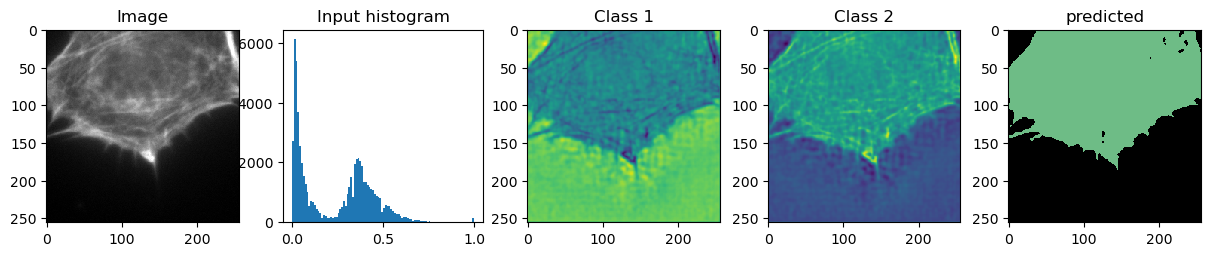

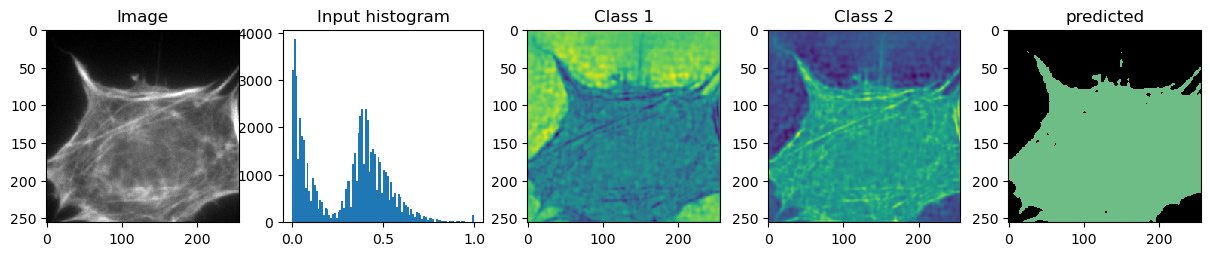

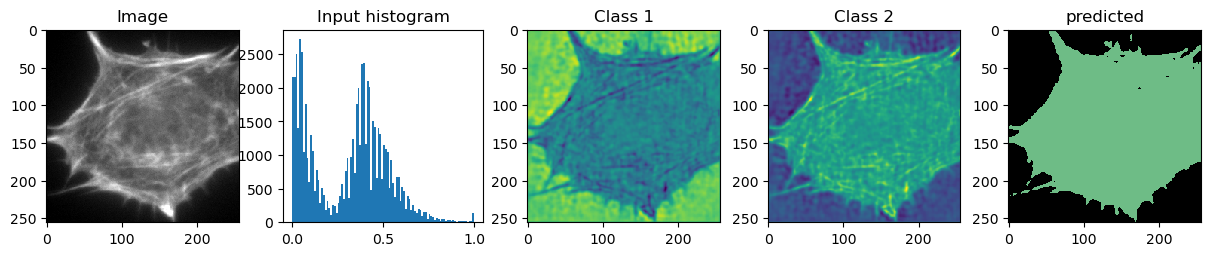

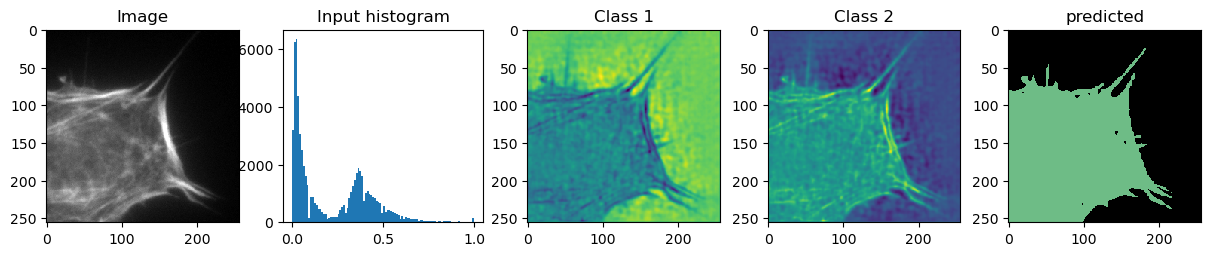

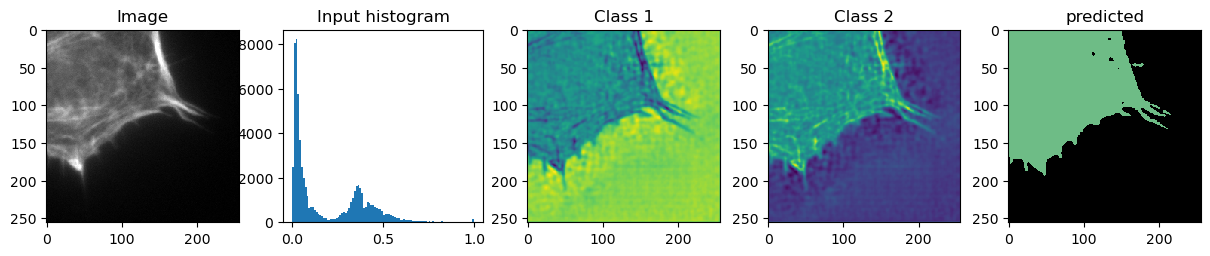

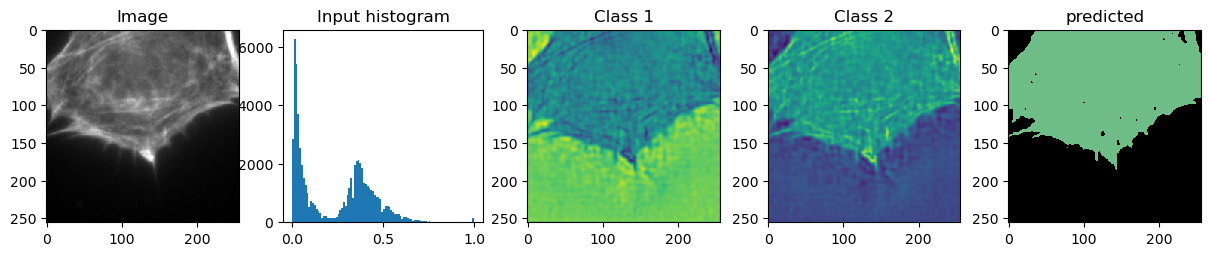

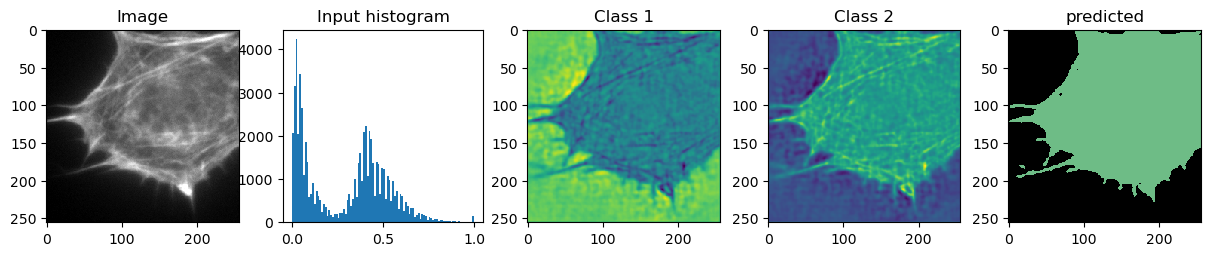

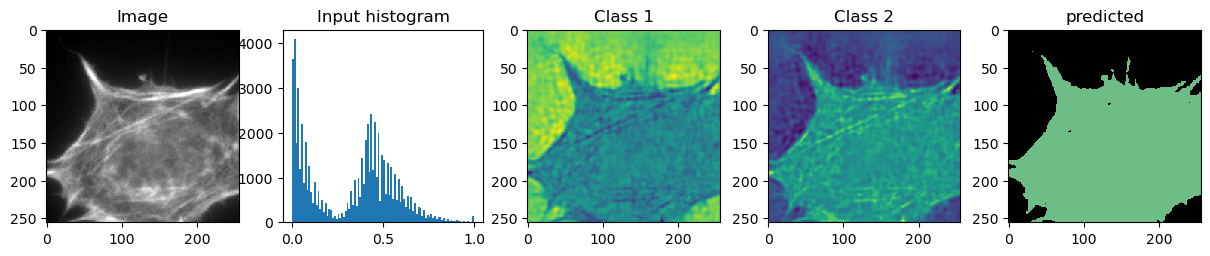

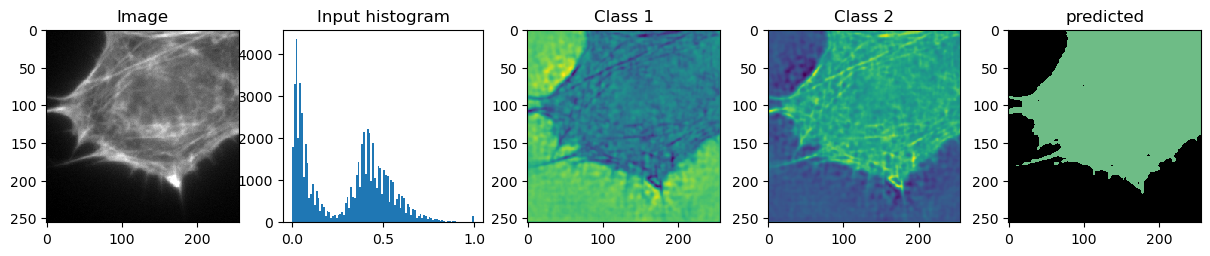

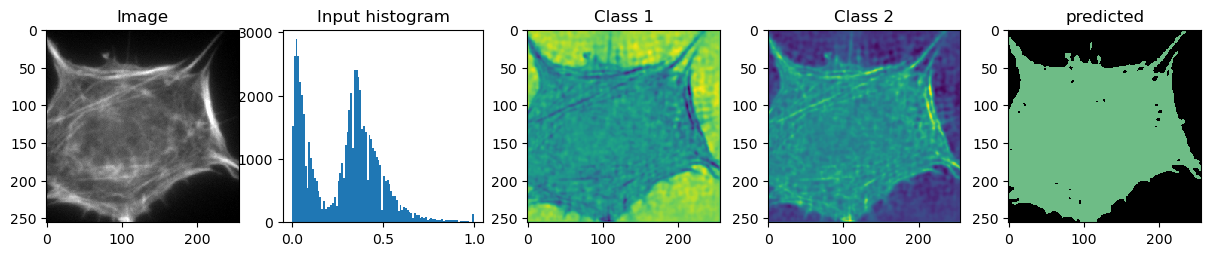

In [27]:
from tnia.plotting.plt_helper import random_label_cmap
rlcm = random_label_cmap()

for i in range(10):
    #features, label = train_loader.dataset[random.randrange(len(train_loader.dataset))]
    
    # random x and y indices
    x = np.random.randint(0, im.shape[1]-256)
    y = np.random.randint(0, im.shape[0]-256)
    size = 256
    im_cropped = im[y:y+size, x:x+size] 

    print('im_cropped min max',im_cropped.shape, im_cropped.min(), im_cropped.max())
    # normalize the image
    im_normalized = quantile_normalization(im_cropped)
    print('im_normalized min max', im_normalized.shape, im_normalized.min(), im_normalized.max(), im_normalized.mean(), im_normalized.dtype)
    im_normalized = im_normalized.astype(np.float32)
    print(im_normalized.shape, im_normalized.min(), im_normalized.max())

    # convert to tensor calling unqueeze twice to add trivial batch and channel dim_normalizedensions
    features_tensor = torch.from_numpy(im_normalized).unsqueeze(0).unsqueeze(0).to(device)       

    net.eval()
    predicted = net(features_tensor)

    predicted.shape
    c1 = predicted[0,0,:,:].cpu().detach().numpy()
    c2 = predicted[0,1,:,:].cpu().detach().numpy()

    # Apply softmax along the class dimension (dim=1)
    probabilities = F.softmax(predicted, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1).cpu().detach().numpy()

    plot_types = 5*['imshow']
    plot_types[1] = 'hist'
    
    fig = imshow_multi2d([im_normalized, im_normalized, c1, c2, predicted_classes], ['Image', 'Input histogram', 'Class 1', 'Class 2', 'predicted'], 1, 5, 15, 2.5,
                         colormaps=['gray', 'gray', 'viridis', 'viridis', rlcm], plottypes=plot_types)